In [103]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import logging

In [2]:
import DeepPiCar.driver.code.hand_coded_lane_follower as lf

In [36]:
frame = cv2.imread('data/laneView1.jpg')
frame1 = cv2.imread('data/laneView2.jpg')
frame2 = cv2.imread('data/laneView3.jpg')

In [63]:
rgb_marble = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
rgb_white = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

In [64]:
## Just using imread RAW

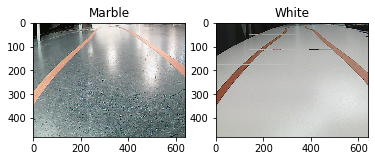

In [66]:
plot_two(frame, frame2, 'Marble', 'White')

In [56]:
def plot_two(f1, f2, title1, title2):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(f1)
    ax[0].set_title(title1)
    ax[1].imshow(f2)
    ax[1].set_title(title2)

In [58]:
## RGB Raw Images

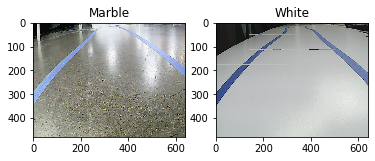

In [67]:
plot_two(rgb_marble, rgb_white, 'Marble', 'White')

In [73]:
## Using the existing Lane Detection Function

In [75]:
lane_lines, lane_lines_image_marble = lf.detect_lane(frame)
lane_lines_white, lane_lines_image_white = lf.detect_lane(frame2)

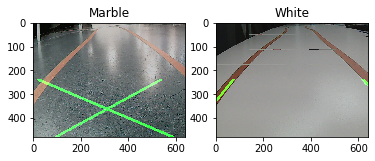

In [76]:
plot_two(lane_lines_image_marble, lane_lines_image_white, 'Marble', 'White')

In [77]:
## Does RGB Change anything?

In [78]:
lane_lines_rgb, lane_lines_image_marble_rgb = lf.detect_lane(rgb_marble)
lane_lines_white_rgb, lane_lines_image_white_rgb = lf.detect_lane(rgb_white)

/Users/reiffd/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/reiffd/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


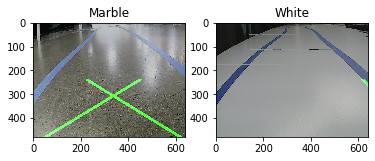

In [79]:
plot_two(lane_lines_image_marble_rgb, lane_lines_image_white_rgb, 'Marble', 'White')

In [ ]:
## It kind of fucks it up. Lets deconstruct this

In [44]:
## HSV Transformation

In [80]:
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
hsv_white = cv2.cvtColor(frame2, cv2.COLOR_BGR2HSV)

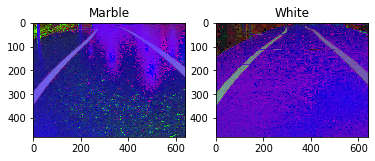

In [81]:
plot_two(hsv, hsv_white, 'Marble', 'White')


In [82]:
## Lift Blue Out

In [83]:
lower_blue = np.array([60, 40, 40])
upper_blue = np.array([150, 255, 255])
mask_marble = cv2.inRange(hsv, lower_blue, upper_blue)
mask_white = cv2.inRange(hsv_white, lower_blue, upper_blue)

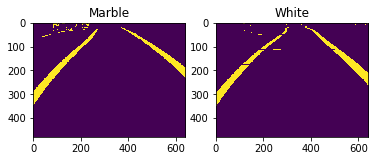

In [84]:
plot_two(mask_marble, mask_white, 'Marble', 'White')

In [85]:
## Detecting the edges of lane lines

In [86]:
edges_marble = cv2.Canny(mask_marble, 200, 400)
edges_white = cv2.Canny(mask_white, 200, 400)

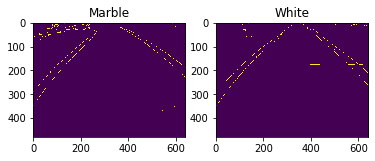

In [87]:
plot_two(edges_marble, edges_white, 'Marble', 'White')

In [90]:
## Putting it together

In [88]:

def detect_edges(frame):
    # filter for blue lane lines
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    show_image("hsv", hsv)
    lower_blue = np.array([60, 40, 40])
    upper_blue = np.array([150, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    show_image("blue mask", mask)

    # detect edges
    edges = cv2.Canny(mask, 200, 400)

    return edges

In [91]:
## Isolate region of interest

In [92]:

def region_of_interest(edges):
    height, width = edges.shape
    mask = np.zeros_like(edges)

    # only focus bottom half of the screen
    polygon = np.array([[
        (0, height * 1 / 2),
        (width, height * 1 / 2),
        (width, height),
        (0, height),
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    cropped_edges = cv2.bitwise_and(edges, mask)
    return cropped_edges

In [93]:
cropped_marble = region_of_interest(edges_marble)
cropped_white = region_of_interest(edges_white)

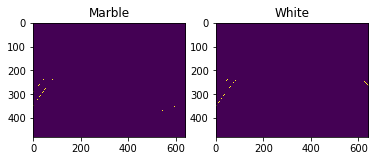

In [94]:
plot_two(cropped_marble, cropped_white, 'Marble', 'White')

In [95]:
## Detect line segments

In [96]:

def detect_line_segments(cropped_edges):
    # tuning min_threshold, minLineLength, maxLineGap is a trial and error process by hand
    rho = 1  # distance precision in pixel, i.e. 1 pixel
    angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
    min_threshold = 10  # minimal of votes
    line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold, 
                                    np.array([]), minLineLength=8, maxLineGap=4)

    return line_segments

In [98]:
line_segments_marble = detect_line_segments(cropped_marble)
line_segments_white = detect_line_segments(cropped_white)

In [100]:
def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        logging.info('No line_segment segments detected')
        return lane_lines

    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    boundary = 1/3
    left_region_boundary = width * (1 - boundary)  # left lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary # right lane line segment should be on left 2/3 of the screen

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                logging.info('skipping vertical line segment (slope=inf): %s' % line_segment)
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    if len(left_fit) > 0:
        lane_lines.append(make_points(frame, left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)
    if len(right_fit) > 0:
        lane_lines.append(make_points(frame, right_fit_average))

    logging.debug('lane lines: %s' % lane_lines)  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

    return lane_lines

In [101]:
def make_points(frame, line):
    height, width, _ = frame.shape
    slope, intercept = line
    y1 = height  # bottom of the frame
    y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

    # bound the coordinates within the frame
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]

In [110]:
lane_lines_marble = average_slope_intercept(frame, line_segments_marble)
lane_lines_white = average_slope_intercept(frame, line_segments_white)

/Users/reiffd/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/reiffd/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [107]:

def display_lines(frame, lines, line_color=(0, 255, 0), line_width=2):
    line_image = np.zeros_like(frame)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
    line_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    return line_image

In [111]:
final_img_marble = display_lines(frame, lane_lines_marble)
final_img_white = display_lines(frame2, lane_lines_white)

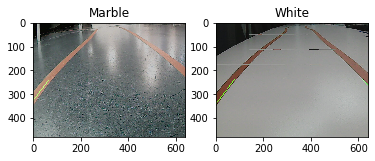

In [112]:
plot_two(final_img_marble, final_img_white, 'Marble', 'White')